
# The structure of this jupyter notebook:
1. Load model
2. Solve model
3. Simulate model
4. Plot model results 

    i. Average over age

    ii. All simulation over age

    iii. Solutions for each grid point over age (2D)
    
    iV. solutions for specific grid points in 3D

5. Welfare analysis
     
    i. Replacement rate

    ii. Consumption replacement rate

    iii. Consumption equivalence

# Load model 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct

# load local model file and initialize model class
from model import ModelClass

In [18]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

# Solve model

In [16]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=True)

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

# Simulate model

In [5]:
%time model.simulate()

CPU times: total: 2.25 s
Wall time: 8.92 s


In [27]:
np.exp(par.beta_1*0 + par.beta_2*30**2)

0.7052520657508226

# Plot model results

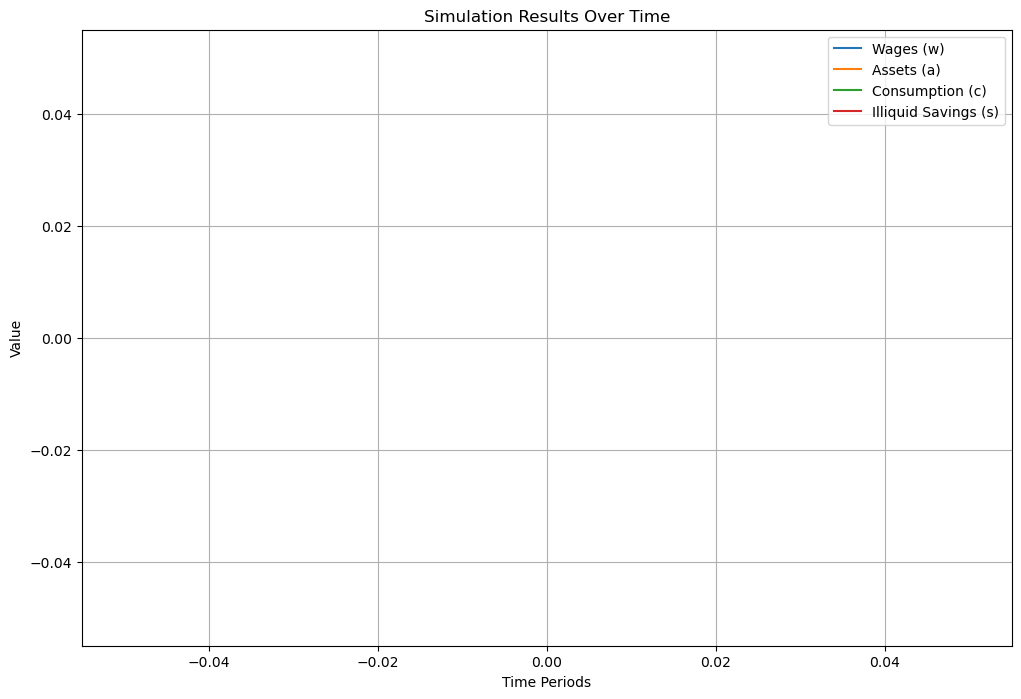

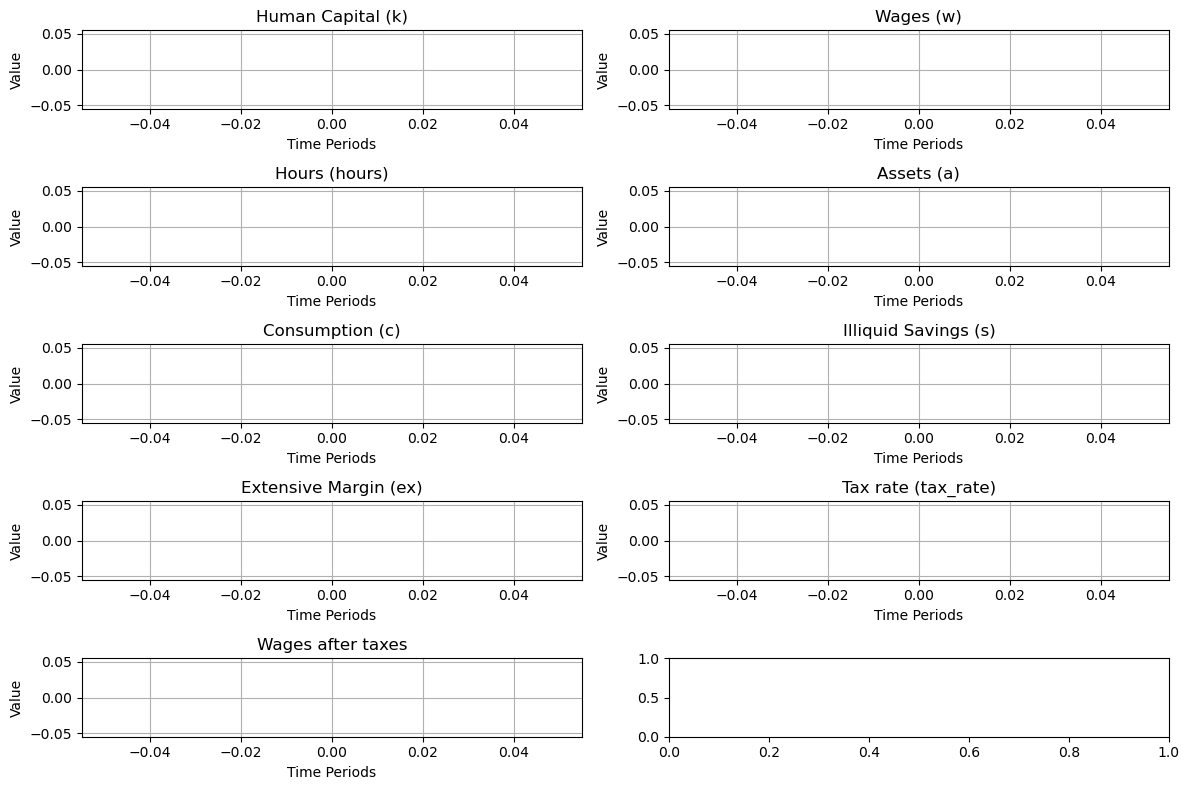

In [21]:
time = np.arange(par.T)

simulated_data = {
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}

# Create a figure and plot each variable
plt.figure(figsize=(12, 8))
for label, data in simulated_data.items():
    plt.plot(time, data, label=label)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": np.mean(model.sim.k[:], axis=0),
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Hours (hours)": np.mean(model.sim.h[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1-model.sim.tax_rate[:,:])*model.sim.w[:,:], axis=0),
}
# Plot each variable in its respective subplot
for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
    ax.plot(time, data)
    ax.set_title(label)
    ax.set_xlabel("Time Periods")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
for i in range(1000):
    data_dict = {
        "Human Capital (k)": model.sim.k[i,:],
        "Wages (w)": model.sim.w[i,:],
        "Hours (hours)": model.sim.h[i,:],
        "Assets (a)": model.sim.a[i,:],
        "Consumption (c)": model.sim.c[i,:],
        "Illiquid Savings (s)": model.sim.s[i,:],
        "Extensive Margin (ex)": model.sim.ex[i,:],
        "Public benefit (chi)": model.sim.chi_payment[i,:],
        "Tax rate (tax_rate)": model.sim.tax_rate[i,:],
        "Wages after taxes": (1-model.sim.tax_rate[i,:])*model.sim.w[i,:],
    }
    # Plot each variable in its respective subplot
    for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
        ax.plot(time, data)
        ax.set_title(label)
        ax.set_xlabel("Time Periods")
        ax.set_ylabel("Value")
        ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
np.mean(np.log(sim.w_init) / par.beta_1)

In [ ]:
np.mean(sim.k_init)

In [ ]:
(np.log(sim.w_init))/par.beta_1

In [ ]:
np.mean(sim.k[:,0])

In [ ]:
plt.hist(sim.w[:,0])

In [ ]:
plt.hist(par.full_time_hours*np.exp( 1/5 * sim.k_init))

In [ ]:
int(833304.1902229205/1000)

In [ ]:
def tax_rate_fct(par, income):
    if income <= par.threshold:
        tax_rate = par.L1*(1-np.exp(-par.K1*income))
    else:
        tax_rate = par.L1*(1-np.exp(-par.K1*income)) + par.L2*(1-np.exp(-par.K2*(income-par.threshold)))
    return tax_rate


In [ ]:
def tax_rate_fct(par, income):
    if income <= par.threshold:
        tax_rate = par.L1*(1-np.exp(-par.K1*income))
    else:
        tax_rate = par.L1*(1-np.exp(-par.K1*income)) + par.L2*(1-np.exp(-par.K2*(income-par.threshold)))
    return tax_rate
tax_rate_list = []
for i in np.arange(np.min(sim.h*sim.w), np.max(sim.h*sim.w), int(np.max(sim.h*sim.w)/10000)):
    tax_rate_list.append(tax_rate_fct(par, i))
plt.plot(np.arange(np.min(sim.h*sim.w), np.max(sim.h*sim.w), int(np.max(sim.h*sim.w)/10000)), tax_rate_list)

In [ ]:
def tax_rate_fct(par, income):
    if income <= par.threshold:
        tax_rate = par.L1*(1-np.exp(-par.K1*income))
    else:
        tax_rate = par.L1*(1-np.exp(-par.K1*income)) + par.L2*(1-np.exp(-par.K2*(income-par.threshold)))
    return tax_rate
tax_rate_list = []
for i in np.arange(np.min(sim.h*sim.w), 3000000, int(np.max(sim.h*sim.w)/10000)):
    tax_rate_list.append(tax_rate_fct(par, i))

income_grid = np.linspace(np.min(sim.h * sim.w), 3000000)
tax_curve = [tax_rate_fct(par, income) for income in income_grid]

plt.figure(figsize=(10, 6))
plt.plot(income_grid, tax_curve, color='tab:blue', linewidth=2)
plt.title("Theoretical Tax Rate Curve", fontsize=16)
plt.xlabel("Income", fontsize=14)
plt.ylabel("Tax Rate", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

income_list = []
tax_rate_list = []
for i in range(par.simT):
    for j in range(par.simN):
        income_list.append(sim.h[j,i]*sim.w[j,i])
        tax_rate_list.append(tax_rate_fct(par, sim.h[j,i]*sim.w[j,i]))
plt.figure(figsize=(10, 6))
plt.scatter(income_list, tax_rate_list)
plt.title("Tax Rate on labour income as a Function of Labour Income", fontsize=16)
plt.xlabel("Income", fontsize=14)
plt.ylabel("Tax Rate on labor income", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
for s in range(par.N_s):
    for k in range(par.N_k):
        for a in range(par.N_a):
            data_dict = {
                "Welfare (V)": model.sol.V[:,a,s,k],
                "Hours (hours)": model.sol.h[:,a,s,k],
                "Assets (a)": model.sol.a[:,a,s,k],
                "Consumption (c)": model.sol.c[:,a,s,k],
                "Consumption, unemployed (c_un)": model.sol.c_un[:,a,s,k],
                "Extensive Margin (ex)": model.sol.ex[:,a,s,k],
            }
        # Plot each variable in its respective subplot
            for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
                ax.plot(time, data)
                ax.set_title(label)
                ax.set_xlabel("Time Periods")
                ax.set_ylabel("Value")
                ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Welfare, 
1. Replacement rate
2. Consumption replacement rate
3. Calculate consumption equivalence

In [ ]:
# calculate replacement rate
replacement_rate = replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Replacement Rate Distribution")
plt.xlabel("Replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
consumption_replacement_rate = consumption_replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(consumption_replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Consumption replacement Rate Distribution")
plt.xlabel("Consumption replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
# theta = [40]
# theta_names = ['retirement_age']
# find_consumption_equivalence(model,theta,theta_names, do_print=True)
